/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-3-174ab6537fc1>:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=data.index[-1], periods=13, freq='M')[1:]


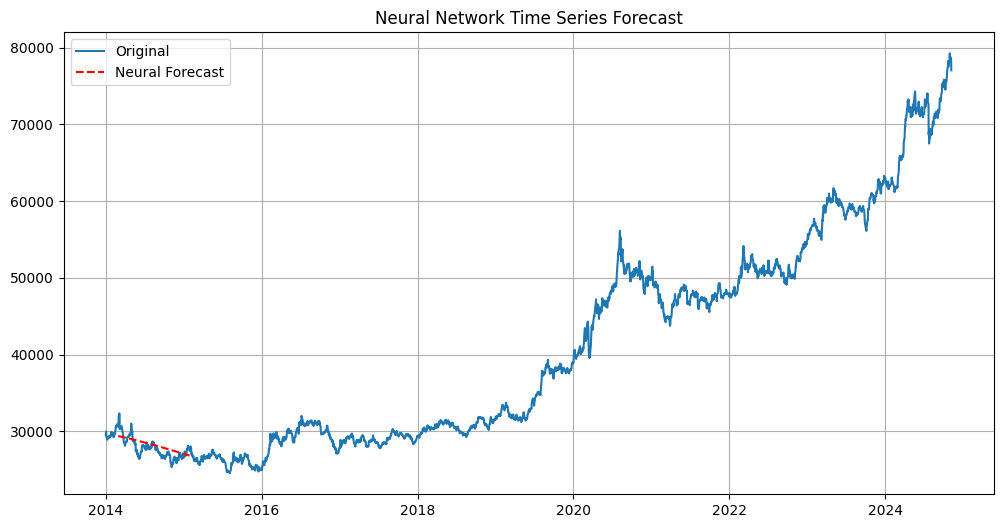

In [3]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Step 2: Load the Dataset
file_path = '/content/Gold_Price_DataSet (1).csv'
df = pd.read_csv(file_path)

# Step 3: Preprocess the Data
df.columns = [col.strip() for col in df.columns]
date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df.set_index(date_col, inplace=True)

# Select the first numeric column
df_numeric = df.select_dtypes(include='number')
value_col = df_numeric.columns[0]
data = df_numeric[[value_col]].dropna()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Step 4: Create Dataset for LSTM
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(x), np.array(y)

window_size = 12
X, y = create_sequences(scaled_data, window_size)

# Step 5: Define and Train the Neural Network
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

model.fit(X, y, epochs=100, verbose=0)

# Step 6: Forecast Future Values
last_sequence = scaled_data[-window_size:]
predictions = []

for _ in range(12):  # Forecast next 12 months
    input_seq = last_sequence.reshape((1, window_size, 1))
    next_val = model.predict(input_seq, verbose=0)[0]
    predictions.append(next_val)
    last_sequence = np.append(last_sequence[1:], [next_val], axis=0)

# Inverse transform predictions
forecast = scaler.inverse_transform(predictions)

# Step 7: Plot Forecast
forecast_index = pd.date_range(start=data.index[-1], periods=13, freq='M')[1:]
forecast_series = pd.Series(forecast.flatten(), index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(data, label='Original')
plt.plot(forecast_series, label='Neural Forecast', color='red', linestyle='--')
plt.title('Neural Network Time Series Forecast')
plt.grid(True)
plt.legend()
plt.show()